# Theta Example

- Read about the [theta model](https://www.sciencedirect.com/science/article/abs/pii/S0169207000000662#:~:text=The%20method%20is%20based%20on,data%20but%20not%20their%20curvatures)
- See the [darts implementation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.theta.html)
- See the [statsmodels implementation](https://www.statsmodels.org/devel/examples/notebooks/generated/theta-model.html#:~:text=The%20Theta%20model%20of%20Assimakopoulos,to%20produce%20the%20final%20forecast)
- Download data from [GitHub](https://github.com/Mcompetitions/M4-methods/tree/master/Dataset)
- Install darts: `pip install darts`

Scalecast ports the model from darts, which is supposed to be more accurate and is also easier to maintain.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from scalecast.Forecaster import Forecaster

In [2]:
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
train = pd.read_csv('Hourly-train.csv',index_col=0)
test = pd.read_csv('Hourly-test.csv',index_col=0)
y = train.loc['H7'].to_list()
current_dates = pd.date_range(start='2015-01-07 12:00',freq='H',periods=len(y)).to_list()

y_test = test.loc['H7'].to_list()
future_dates = pd.date_range(start=max(current_dates) + pd.Timedelta(hours=1),freq='H',periods=len(y_test)).to_list()

f = Forecaster(y=y,current_dates=current_dates)
f

Forecaster(
    DateStartActuals=2015-01-18T08:00:00.000000000
    DateEndActuals=2015-02-16T11:00:00.000000000
    Freq=H
    N_actuals=700
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

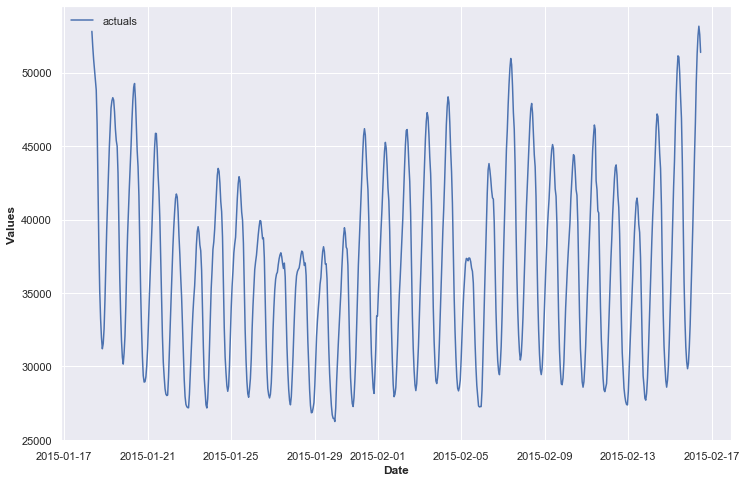

In [4]:
f.plot()
plt.show()

## Prepare forecast
- 25% test length
- 48 period forecast horizon
- Monitor validation MAPE to select hyperparams

In [5]:
f.set_test_length(.25)
f.generate_future_dates(48)
f.set_validation_metric('mape')

## Build Hypeparameter grid
- The below grid gives a good chance of finding the best model for your dataset
- You might want to add more values to the `theta` parameter

In [6]:
theta_grid = {
    'theta':[0.5,1,1.5,2,2.5,3],
    'model_mode':[
        ModelMode.ADDITIVE,
        ModelMode.MULTIPLICATIVE
    ],
    'season_mode':[
        SeasonalityMode.MULTIPLICATIVE,
        SeasonalityMode.ADDITIVE
    ],
    'trend_mode':[
        TrendMode.EXPONENTIAL,
        TrendMode.LINEAR
    ],
}

## Call the forecast
- tune hyperparemters with 3-fold time series cross validation

In [7]:
f.set_estimator('theta')
f.ingest_grid(theta_grid)
f.cross_validate(k=3)
f.auto_forecast()

## Visualize test results

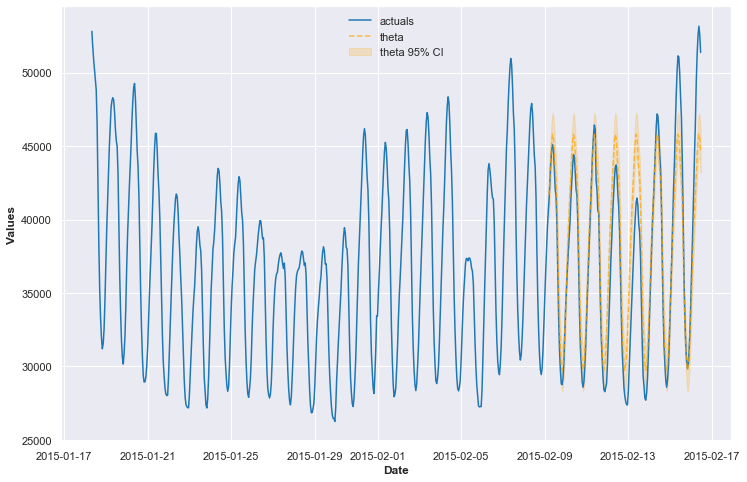

In [8]:
f.plot_test_set(ci=True)
plt.show()

## Visualize forecast results

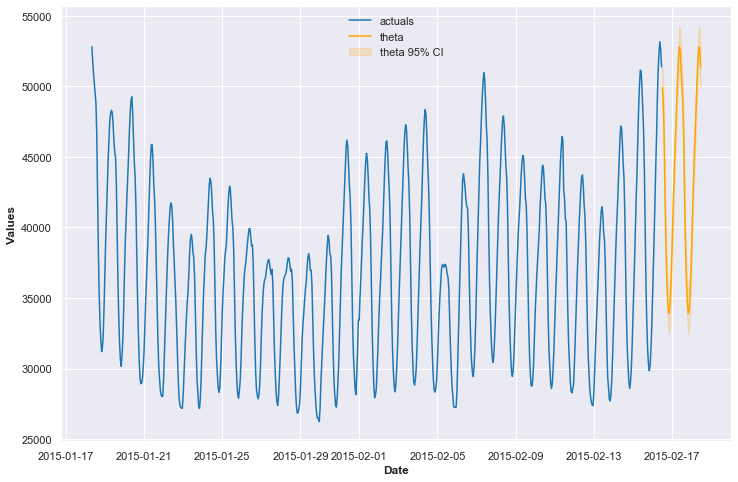

In [9]:
f.plot(ci=True)
plt.show()

## Which parameters were chosen from the grid search?

In [10]:
f.best_params

{'theta': 1,
 'model_mode': <ModelMode.ADDITIVE: 'additive'>,
 'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>}

## See in-sample and out-of-sample accuracy/error metrics

In [11]:
results = f.export('model_summaries')

In [17]:
results[['TestSetMAPE','InSampleMAPE','TestSetR2','InSampleR2','ValidationMetric','ValidationMetricValue','TestSetLength']]

,TestSetMAPE,InSampleMAPE,TestSetR2,InSampleR2,ValidationMetric,ValidationMetricValue,TestSetLength
0,0.055214,0.013836,0.836167,0.985878,mape,0.075016,175


The validation metric displayed above is the average MAPE across the three cross-validation folds.

In [13]:
validation_grid = f.export_validation_grid('theta')
validation_grid.head()

,theta,model_mode,season_mode,trend_mode,validation_length,validation_metric,metric_value,fold,rolling,train_length
0,0.5,ModelMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.EXPONENTIAL,131,mape,0.057713,0,False,394
1,0.5,ModelMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.LINEAR,131,mape,0.057325,0,False,394
2,0.5,ModelMode.ADDITIVE,SeasonalityMode.ADDITIVE,TrendMode.EXPONENTIAL,131,mape,0.058284,0,False,394
3,0.5,ModelMode.ADDITIVE,SeasonalityMode.ADDITIVE,TrendMode.LINEAR,131,mape,0.058007,0,False,394
4,0.5,ModelMode.MULTIPLICATIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.EXPONENTIAL,131,mape,0.057400,0,False,394


## Test the forecast against out-of-sample data
- this is data the `Forecaster` object has never seen

In [14]:
fcst = f.export('lvl_fcsts')
fcst.head()

,DATE,theta
0,2015-02-16 12:00:00,49923.776907
1,2015-02-16 13:00:00,49139.816948
2,2015-02-16 14:00:00,47132.417244
3,2015-02-16 15:00:00,43425.794415
4,2015-02-16 16:00:00,39876.248396


In [15]:
mape = np.mean([(f - a) / a for f, a in zip(fcst['theta'],y_test)])
mape

0.06042762265481331

## Backtest model
- use the last 10 forecast horizons of 48 periods to obtain an average performance of the model on out-of-sample trials
- place 6 periods between each successive training set

In [16]:
f.backtest('theta',jump_back=6)
f.export_backtest_metrics('theta')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,2728.47714,2516.572304,3284.693744,5293.506222,4117.926382,4410.432485,4210.277454,2328.326183,2427.749407,1670.050667,3298.801199
MAE,2104.867268,1854.53207,2514.034428,4594.756317,3203.309971,3857.888031,3547.607099,1958.353354,1977.457234,1351.534646,2696.434042
R2,0.883453,0.874903,0.783414,0.489332,0.679812,0.448884,0.50641,0.860034,0.840146,0.906029,0.727242
MAPE,0.048612,0.042851,0.05822,0.110612,0.076325,0.101709,0.094976,0.053409,0.056318,0.038957,0.068199
